In [ ]:

#Distinguere le categorie dataset, come?
#Nomi Features
#Numero o tipo features
#Metadati!
#Metodi di raccolta




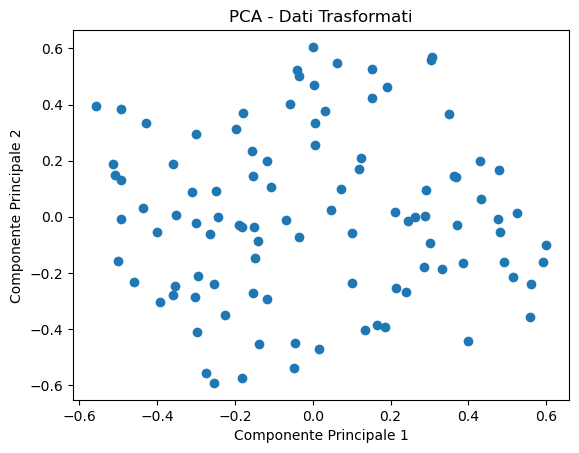

In [15]:
#PCA
from sklearn.decomposition import PCA

#Random data example
np.random.seed(42)
punti = np.random.rand(100, 3)  #Esempio con 100 campioni e 3 dimensioni
#print(data)
#numero componenti (esempio 2D)
num_components = 2
pca = PCA(n_components=num_components)

#fit
pca.fit(punti)

#transform pca
punti_transformed = pca.transform(punti)

#plot
plt.scatter(punti_transformed[:, 0], punti_transformed[:, 1])
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.title('PCA - Dati Trasformati')
plt.show()


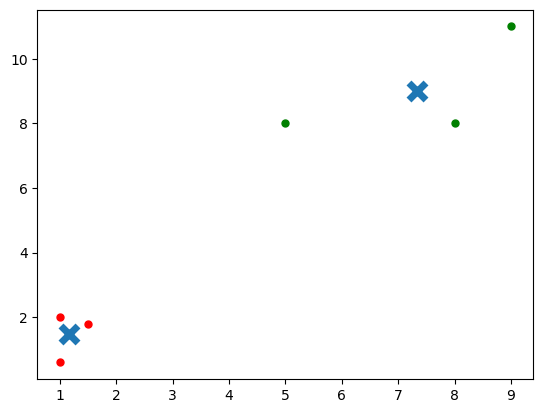

In [4]:
#CLUSTERING 

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt


#K-MEANS

#Esempio punti
data = np.array([[1, 2], [5, 8], [1.5, 1.8], [8, 8], [1, 0.6], [9, 11]])

num_clusters = 2

kmeans = KMeans(n_clusters=num_clusters)

#Addestramento
kmeans.fit(data)

#Labels e centroidi
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

#Plot in 2D
colors = ['r.', 'g.', 'b.', 'y.']
for i in range(len(data)):
    plt.plot(data[i][0], data[i][1], colors[labels[i]], markersize=10)

plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=150, linewidths=5, zorder=10)
plt.show()


Numero di cluster trovati: 2


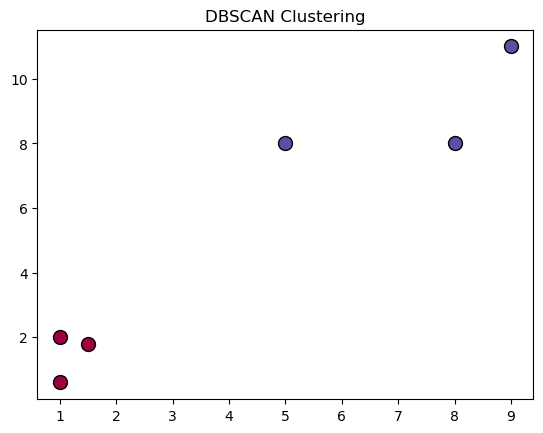

In [9]:
#DBSCAN (Density based) parametri da impostare correttamente distanza eps, e min samples = numero minimo di punti
dbscan = DBSCAN(eps=4, min_samples=2) 

# Addestramento
dbscan.fit(data)

# Labels e numero cluster
labels = dbscan.labels_
num_clusters = len(set(labels)) - (1 if -1 in labels else 0) #ignora noise con if else
print(f"Numero di cluster trovati: {num_clusters}")

#Plot
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Rumore, lo visualizziamo in nero
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = data[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=10)

plt.title('DBSCAN Clustering')
plt.show()